Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514 / EEL7513 / EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 8: Redes Convolucionais

Neste exercício você irá utilizar redes convolucionais para reconhecimento de imagens. Além de treinar uma rede a partir do zero, você irá investigar a técnica de ajuste fino (*fine tuning*) a partir de uma rede pré-treinada (*transfer learning*).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [186]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import sys
import tensorflow as tf
print('Python', sys.version.split(' ')[0])
print('TensorFlow', tf.__version__)
#print('GPU:', tf.config.list_physical_devices('GPU'))
devs = tf.python.client.device_lib.list_local_devices()
devs = {devs[i].device_type: devs[i].physical_device_desc for i in range(len(devs))}
if 'GPU' in devs:
  print('GPU:', devs['GPU'].split('name: ')[1].split(', ')[0])
else:
  print('GPU: None')

Python 3.6.9
TensorFlow 2.3.0
GPU: Tesla K80


In [187]:
def plots(history):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.history.keys():
    plt.plot(history.history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.grid();
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.history.keys():
    plt.plot(history.history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

# 1. Treinando a partir do zero

## MNIST

1. Assim como no exercício anterior, carregue o conjunto MNIST e separe as últimas 5000 imagens como conjunto de validação. No entanto, desta vez não realize qualquer pré-processamento nas imagens (como escalonamento); isto será feito [internamente no modelo](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) depois.

In [209]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [210]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000)

In [211]:
#x_train = x_train.astype('uint8')
#print(x_train.dtype)
print(f'Train shapes: {x_train.shape, y_train.shape}')
print(f'  Val shapes: {x_val.shape, y_val.shape}')
print(f' Test shapes: {x_test.shape, y_test.shape}')

Train shapes: ((55000, 28, 28), (55000,))
  Val shapes: ((5000, 28, 28), (5000,))
 Test shapes: ((10000, 28, 28), (10000,))


2. Usando o Keras, construa uma rede neural com pelo menos uma camada convolucional (`tf.keras.layers.Conv2D`) e confirme que não há nenhum erro de definição. Organize seu código em uma função de criação do modelo, conforme o exemplo abaixo (dê o nome que preferir). Utilize camadas de escalonamento e *reshape* conforme necessário.

#### Dicas
- Funções úteis: `tf.keras.layers.experimental.preprocessing.Rescaling`, `tf.keras.layers.Reshape`
- Camadas convolucionais 2D exigem que a entrada seja um tensor 3D, sendo o último eixo correspondente ao número de canais (no caso, apenas 1, para uma imagem em tons de cinza).

In [212]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras        import layers

In [217]:
def make_model():
  tf.random.set_seed(50)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape=(28,28,1)),
        layers.BatchNormalization(scale=False),
        layers.MaxPool2D(2,2),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
        layers.BatchNormalization(scale=False),
        layers.MaxPool2D(2,2),

        layers.Flatten(),
        layers.Dropout(0.2),
        Dense(128, activation = 'relu'),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_49 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling_50 (Rescaling)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_70 (Batc (None, 28, 28, 64)        192       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_71 (Batc (None, 14, 14, 64)      

In [218]:
%%time
model = make_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val,y_val), verbose = True)

Epoch 1/10
430/430 [==============================] - 6s 14ms/step - loss: 0.1641 - accuracy: 0.9514 - val_loss: 1.6488 - val_accuracy: 0.7850
Epoch 2/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0503 - accuracy: 0.9843 - val_loss: 0.0670 - val_accuracy: 0.9778
Epoch 3/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.0442 - val_accuracy: 0.9880
Epoch 4/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0465 - val_accuracy: 0.9874
Epoch 5/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.0401 - val_accuracy: 0.9892
Epoch 6/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0675 - val_accuracy: 0.9836
Epoch 7/10
430/430 [==============================] - 6s 13ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 0.0710 - val_accuracy: 0.9810

157/157 [==============================] - 1s 4ms/step - loss: 0.0574 - accuracy: 0.9884


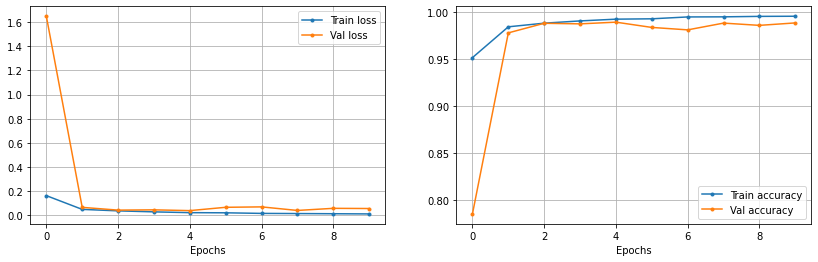

In [219]:
model.evaluate(x_train,y_train)
model.evaluate(x_val,y_val)
plots(history)

3. Desenvolva (i.e., aprimore a arquitetura) e treine sua rede (a partir do zero), tentando conseguir uma acurácia de validação de pelo menos 99.2%. (Lembre que usando apenas camadas densas é difícil conseguir uma acurácia muito superior a 98%.) Em seguida, calcule a acurácia no conjunto de teste.

1. (OPCIONAL) Por que o uso de Dropout faz com que o desempenho de treinamento comece bastante inferior ao de validação?

#### Dicas
- Parta da arquitetura deste [tutorial](https://keras.io/examples/vision/mnist_convnet) (com os devidos ajustes feitos no item anterior) e adicione uma camada densa com um número suficiente de unidades. Lembre-se de (ao contrário do tutorial) trazer para dentro do modelo qualquer pré-processamento necessário.
- Visualize os gráficos do treinamento usando a função `plots` fornecida (ou a ferramenta TensorBoard).
- Ao usar camadas convolucionais com GPU, a execução paralelizada torna impossível garantir a reproducibilidade, portanto, não perca tempo com isso.

In [242]:
def make_model():
  tf.random.set_seed(100)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(256, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_57 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling_58 (Rescaling)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_86 (Batc (None, 26, 26, 64)        192       
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 11, 11, 64)        36928     
_________________________________________________________________
batch_normalization_87 (Batc (None, 11, 11, 64)      

In [229]:
%%time
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val,y_val), verbose = True)

Epoch 1/20
430/430 [==============================] - 6s 13ms/step - loss: 0.1911 - accuracy: 0.9395 - val_loss: 2.4250 - val_accuracy: 0.1126
Epoch 2/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0610 - accuracy: 0.9818 - val_loss: 0.1344 - val_accuracy: 0.9596
Epoch 3/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0446 - accuracy: 0.9861 - val_loss: 0.0549 - val_accuracy: 0.9838
Epoch 4/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.0655 - val_accuracy: 0.9822
Epoch 5/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0472 - val_accuracy: 0.9864
Epoch 6/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0387 - val_accuracy: 0.9904
Epoch 7/20
430/430 [==============================] - 5s 12ms/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.0582 - val_accuracy: 0.9844

In [232]:
# tentando conseguir uma acurácia de validação de pelo menos 99.2%.
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate = model.evaluate(x_val,y_val)
test_evaluate = model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0442 - accuracy: 0.9913


In [233]:
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')
print(f' Test evaluate: {round(test_evaluate[1],3)*100}%')

Train evaluate: 99.8%
  Val evaluate: 99.0%
 Test evaluate: 99.1%


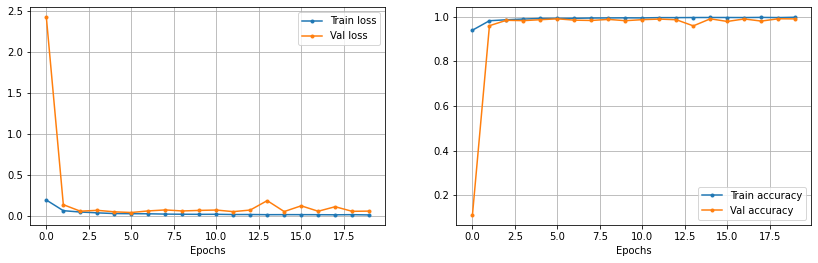

In [234]:
plots(history) #batch_size=128, epochs=20

In [235]:
'''
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('model_mnist.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('model_mnist.h5')
'''

In [ ]:
'''
from keras.models import model_from_json

file = open('model_mnist.json', 'r')
model = file.read()
file.close()

model = model_from_json(model)
model.load_weights('model_mnist.h5')
'''

4.(OPCIONAL) Por que o uso de Dropout faz com que o desempenho de treinamento comece bastante inferior ao de validação? 

Essa técnica zera alguns valores das camadas, fazendo com que a rede se reajuste a determinados valores e vá aprendendo com o decorrer das épocas, tornando o início do treinamento bastante inferior.

---

## (OPCIONAL) Fashion-MNIST

5. (OPCIONAL) Repita para o conjunto [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), o qual também está [disponível no Keras](https://keras.io/api/datasets/fashion_mnist). Nesse caso, é suficiente aproveitar a mesma arquitetura do modelo e apenas (se necessário) alterar a taxa de aprendizado e o número de épocas. Sem muito esforço é possível conseguir uma acurácia de validação de 92% (em comparação com 87% para uma rede densa). Se desejar, visualize algumas imagens do conjunto de treinamento e algumas predições erradas no conjunto de teste.

In [239]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [240]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000)

In [241]:
print(f'Train shapes: {x_train.shape, y_train.shape}')
print(f'  Val shapes: {x_val.shape, y_val.shape}')
print(f' Test shapes: {x_test.shape, y_test.shape}')

Train shapes: ((55000, 28, 28), (55000,))
  Val shapes: ((5000, 28, 28), (5000,))
 Test shapes: ((10000, 28, 28), (10000,))


In [252]:
def make_model():
  tf.random.set_seed(100)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_61 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling_62 (Rescaling)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization_96 (Batc (None, 26, 26, 64)        192       
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 11, 11, 64)        36928     
_________________________________________________________________
batch_normalization_97 (Batc (None, 11, 11, 64)      

In [270]:
%%time
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val,y_val), verbose = True)

Epoch 1/10
430/430 [==============================] - 7s 16ms/step - loss: 0.4897 - accuracy: 0.8219 - val_loss: 1.8327 - val_accuracy: 0.5802
Epoch 2/10
430/430 [==============================] - 6s 15ms/step - loss: 0.3282 - accuracy: 0.8791 - val_loss: 0.3736 - val_accuracy: 0.8624
Epoch 3/10
430/430 [==============================] - 6s 15ms/step - loss: 0.2868 - accuracy: 0.8939 - val_loss: 0.4220 - val_accuracy: 0.8442
Epoch 4/10
430/430 [==============================] - 6s 15ms/step - loss: 0.2595 - accuracy: 0.9047 - val_loss: 0.2855 - val_accuracy: 0.8988
Epoch 5/10
430/430 [==============================] - 6s 15ms/step - loss: 0.2353 - accuracy: 0.9124 - val_loss: 0.3011 - val_accuracy: 0.8946
Epoch 6/10
430/430 [==============================] - 6s 15ms/step - loss: 0.2153 - accuracy: 0.9213 - val_loss: 0.2643 - val_accuracy: 0.9108
Epoch 7/10
430/430 [==============================] - 6s 15ms/step - loss: 0.1955 - accuracy: 0.9274 - val_loss: 0.2603 - val_accuracy: 0.9096

In [272]:
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate = model.evaluate(x_val,y_val)
test_evaluate = model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2745 - accuracy: 0.9064


In [273]:
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')
print(f' Test evaluate: {round(test_evaluate[1],3)*100}%')

Train evaluate: 95.6%
  Val evaluate: 90.9%
 Test evaluate: 90.60000000000001%


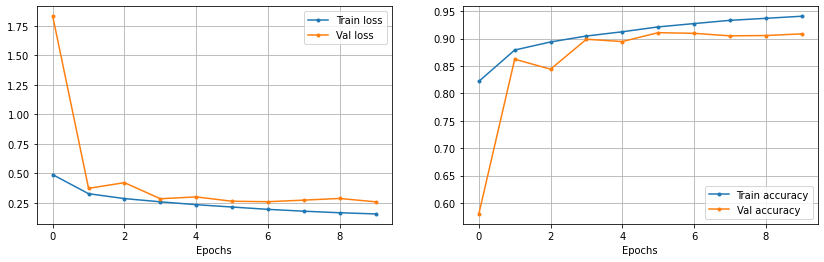

In [274]:
plots(history)

In [338]:
y_pred = model.predict_classes(x_test)
error = np.where(y_pred != y_test)
error

(array([  17,   23,   25,   27,   42,   43,   49,   57,   66,   67,   68,
          89,   98,  127,  135,  141,  147,  150,  153,  155,  213,  217,
         229,  241,  244,  247,  248,  266,  271,  316,  324,  325,  332,
         378,  379,  381,  382,  395,  396,  437,  441,  444,  452,  454,
         457,  460,  476,  478,  491,  499,  510,  526,  529,  547,  569,
         572,  578,  585,  628,  634,  635,  639,  659,  661,  664,  665,
         670,  674,  681,  688,  689,  711,  719,  724,  732,  738,  743,
         751,  753,  760,  787,  793,  800,  801,  851,  860,  890,  893,
         902,  905,  910,  921,  924,  925,  930,  935,  937,  938,  939,
         956,  960,  965,  972,  976,  977,  979,  994, 1000, 1005, 1025,
        1055, 1064, 1066, 1101, 1111, 1131, 1142, 1158, 1162, 1174, 1188,
        1194, 1197, 1210, 1231, 1234, 1254, 1259, 1280, 1285, 1297, 1300,
        1305, 1306, 1326, 1329, 1335, 1336, 1356, 1368, 1387, 1388, 1408,
        1425, 1431, 1438, 1462, 1469, 

Label	Description

0	T-shirt/top\
1	Trouser\
2	Pullover\
3	Dress\
4	Coat\
5	Sandal\
6	Shirt\
7	Sneaker\
8	Bag\
9	Ankle boot\

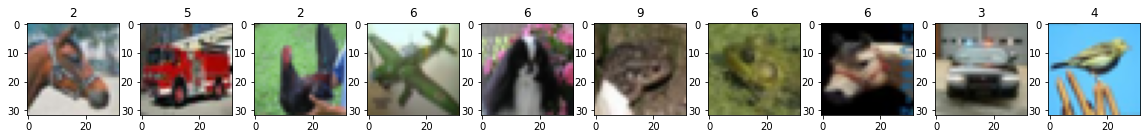

In [356]:
plt.figure(figsize=(20,20))
for c in range(10):
    plt.subplot(10,10,c+1)
    idx = error[0][c]
    plt.imshow(x_test[idx])
    plt.title(f'{y_pred[idx]}')

---

## CIFAR-10

Agora, vamos utilizar um conjunto um pouco mais complexo, o [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), também [disponível no Keras](https://keras.io/datasets/).


In [346]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train.dtype: uint8
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Observe que o `shape` do array `y` precisa ser corrigido:
- Para usar a perda `sparse_categorical_crossentropy`, `y` precisa ser um tensor 1D com valores em `[0, 1, ..., n_classes-1]`
- Para usar a perda `categorical_crossentropy`, `y` precisa ser um tensor 2D com *shape* `(n_samples, n_classes)` e codificação *one-hot*


In [ ]:
# Make sure y is a 1D tensor, so we can use sparse_categorical_crossentropy loss
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000,)
(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


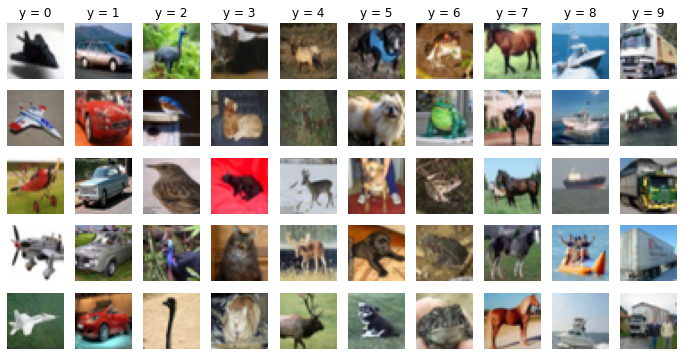

In [ ]:
plt.figure(figsize=(12,6))
for i in range(5):
  for c in range(10):
    plt.subplot(5, 10, 10*i+c+1)
    img = x_train[y_train == c][i]
    plt.imshow(img)
    if i == 0:
      plt.title('y = {}'.format(c))
    plt.axis('off')

6. Inicialmente, apenas converta a mesma arquitetura utilizada no MNIST para o formato das imagens do CIFAR-10 e treine o modelo. Note que agora não é mais necessário usar uma camada `Reshape`. Certifique-se de escolher um batch size e taxa de aprendizado apropriadas. Observe que é difícil obter uma acurácia de validação superior a 73%.

7. Por que você acha que isso acontece? Explique.

In [ ]:
def make_model():
  tf.random.set_seed(1)
  model = Sequential(
      [
        layers.Input(shape = (32,32,3)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 64)        192       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        192       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)         

In [ ]:
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=150, validation_data=(x_val,y_val))

In [ ]:
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate  = model.evaluate(x_val,y_val)
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')

157/157 [==============================] - 1s 4ms/step - loss: 1.8008 - accuracy: 0.7354


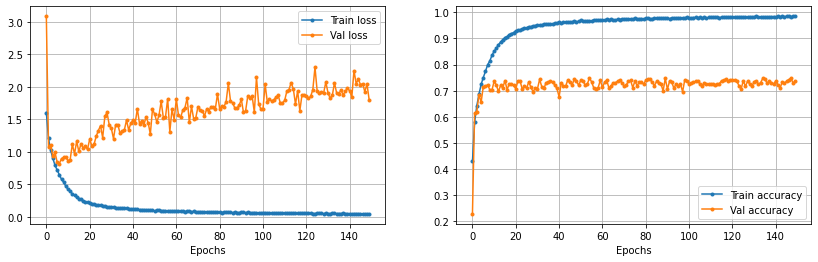

In [ ]:
plots(history)

Observe que é difícil obter uma acurácia de validação superior a 73%.
Por que você acha que isso acontece? Explique.

Resposta: Algumas imagens requerem uma fase de pré-processamento, pois estão com certas inclinações, zoom, oclusão, etc. Isso dificulta a generalização da rede.

In [ ]:
'''
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('CIFAR.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('CIFAR.h5')
'''

In [ ]:
'''
from keras.models import model_from_json

file = open('CIFAR.json', 'r')
model = file.read()
file.close()

model = model_from_json(model)
model.load_weights('CIFAR.h5')
'''

"\nfrom keras.models import model_from_json\n\nfile = open('CIFAR.json', 'r')\nmodel = file.read()\nfile.close()\n\nmodel = model_from_json(model)\nmodel.load_weights('CIFAR.h5')\n"

---

### Data augmentation
Para melhorar o desempenho, utilizaremos a técnica de aumento de dados (*data augmentation*). Há duas formas principais de utilizar esta técnica no Keras:
- Usando a função [`tf.keras.preprocessing.image.ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), a qual opcionalmente permite aplicar transformações aleatórias. Esta é a abordagem mais tradicional.
- Usando camadas de *data augmentation* como parte do modelo, as quais aplicam transformações aleatórias *somente* durante o treinamento (ficando inativas fora do treinamento). Esta é uma abordagem mais recente e ainda experimental. A principal vantagem é tornar as operações mais rápidas pelo uso da GPU, conforme explicado [neste tutorial](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e também [neste](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).

Para acelerar o treinamento usaremos aqui a segunda abordagem. Um exemplo é mostrado abaixo; você pode adicionar outras transformações se desejar.



In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation
data_augmentation = Sequential(
    [
     RandomTranslation(height_factor=0.1, width_factor=0.1),
     RandomFlip(mode='horizontal'),
    ],
    name='data_augmentation',
)

In [ ]:
def make_model():
  model = Sequential(
      [
        layers.Input(shape=(32, 32, 3)),
        data_augmentation,
       
        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
       
        layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.3),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.3),
        Dense(10, activation='softmax'),
      ]
  )
  return model
make_model().summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        96        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 64)        192       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)        

**Obs:** Aparentemente há um bug ainda não resolvido nas camadas `RandomTranslation` e `RandomRotation`, conforme descrito [aqui](https://stackoverflow.com/questions/62339559/black-pixels-outside-the-border-when-using-keras-layers-experimental-preprocessi) e visualizado por exemplo [aqui](https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation), [aqui](https://keras.io/guides/transfer_learning/#using-random-data-augmentation) e nas imagens abaixo. (Não deveria haver bordas pretas nas imagens transformadas.) Felizmente esse defeito não afeta o desempenho de forma significativa.

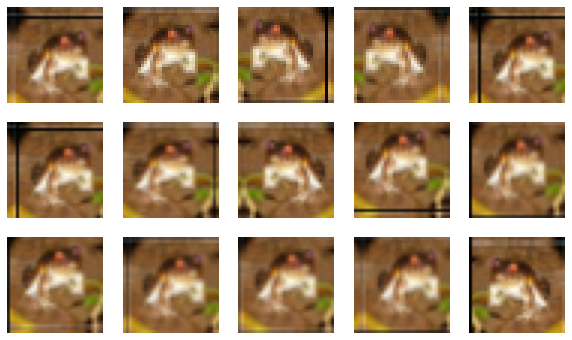

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for j in range(15):
  img = data_augmentation(x_train[[i]])[0].numpy()
  plt.subplot(3, 5, j+1)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')

8. Treine o modelo até obter pelo menos 80% de acurácia de validação. Note que será preciso um número elevado de épocas (100 ou mais), o que deve levar vários minutos.

#### Dicas
- Certifique-se de usar uma taxa de aprendizado apropriada ao longo de todo o treinamento. Por exemplo:
 - Treine por N épocas com taxa constante, observe os resultados, depois continue o treinamento por mais N épocas, etc. Se em algum ponto o desempenho não estiver melhorando, reduza manualmente a taxa de aprendizado;
 - Utilize uma *callback* de decaimento, como [`ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/) ou a genérica [`LearningRateScheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/); ou
 - Utilize um valor pequeno constante e tenha bastante paciência.

-  Fique à vontade para aprimorar o modelo se desejar. Para facilitar, você pode se basear em quaisquer outras referências ou tutoriais disponíveis, como por exemplo: [Tutorial 1](https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras) ou [Tutorial 2](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification). Note que alguns tutoriais estão desatualizados; por exemplo, a função `fit_generator` tornou-se obsoleta, tendo sido incorporada à função `fit`. No entanto, esteja ciente de que não é necessário um modelo muito complexo para obter a acurácia desejada.

In [ ]:
%%time
model = make_model()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# monitor: quantity to be monitored.
# factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
# patience: number of epochs with no improvement after which learning rate will be reduced.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)

history = model.fit(x_train, y_train, batch_size=256, epochs=150, validation_data=(x_val,y_val), callbacks=[reduce_lr])

Epoch 1/150
176/176 [==============================] - 4s 26ms/step - loss: 1.9082 - accuracy: 0.3080 - val_loss: 1.7162 - val_accuracy: 0.3818
Epoch 2/150
176/176 [==============================] - 4s 24ms/step - loss: 1.5249 - accuracy: 0.4523 - val_loss: 1.4894 - val_accuracy: 0.4820
Epoch 3/150
176/176 [==============================] - 4s 24ms/step - loss: 1.3547 - accuracy: 0.5178 - val_loss: 1.1635 - val_accuracy: 0.5868
Epoch 4/150
176/176 [==============================] - 4s 24ms/step - loss: 1.2389 - accuracy: 0.5649 - val_loss: 1.2517 - val_accuracy: 0.5824
Epoch 5/150
176/176 [==============================] - 4s 23ms/step - loss: 1.1522 - accuracy: 0.5984 - val_loss: 1.2171 - val_accuracy: 0.5904
Epoch 6/150
176/176 [==============================] - 4s 23ms/step - loss: 1.0854 - accuracy: 0.6225 - val_loss: 1.3915 - val_accuracy: 0.5638
Epoch 7/150
176/176 [==============================] - 4s 23ms/step - loss: 1.0293 - accuracy: 0.6433 - val_loss: 1.3849 - val_accuracy:

157/157 [==============================] - 1s 4ms/step - loss: 0.5199 - accuracy: 0.8372
Train evaluate: 90.0%
  Val evaluate: 83.7%


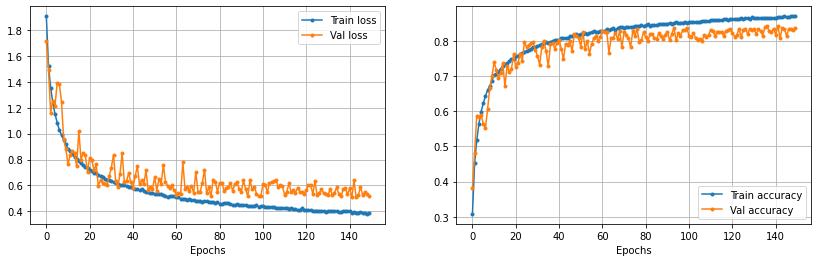

In [ ]:
train_evaluate = model.evaluate(x_train,y_train)
val_evaluate  = model.evaluate(x_val,y_val)
print(f'Train evaluate: {round(train_evaluate[1],3)*100}%')
print(f'  Val evaluate: {round(val_evaluate[1],3)*100}%')
plots(history)

In [ ]:
'''
# armazenando o modelo num arquivo .json
model_json = model.to_json()
with open('CIFAR_callbacks.json', 'w') as json_file:
  json_file.write(model_json)

# armazenando os pesos num arquivo .h5
model.save_weights('CIFAR_callbacks.h5')
'''

# 2. Usando uma rede pré-treinada (*transfer learning & fine-tuning*)

1. Partindo de alguma [rede pré-treinada](https://keras.io/applications/)  fornecida pelo Keras, treine uma rede convolucional para [classificação entre gatos e cachorros](https://www.kaggle.com/c/dogs-vs-cats). Para isto, siga este [tutorial](https://keras.io/guides/transfer_learning) (provavelmente o mais atualizado no momento e escrito pelo próprio criador do Keras). Antes de seguir o tutorial, provavelmente será útil conhecer os conceitos básicos da [API funcional](https://keras.io/guides/functional_api/) do Keras.
1. (OPCIONAL) Experimente outros modelos pré-treinados e/ou outros conjuntos de dados. O [tutorial específico sobre EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) pode ser interessante.
1. (OPCIONAL) Se desejar, você pode aplicar um modelo pré-treinado para classificaro CIFAR-10. No entanto, para obter um desempenho satisfatório nesse caso, será necessário previamente alargar (*resize*) as imagens para um tamanho mais próximo do das imagens da ImageNet (`224 x 224`), para que os filtros treinados possam ser relevantes. Por outro lado, um alargamento excessivo pode introduzir distorções (*artifacts*) que podem prejudicar o desempenho.

#### Dicas
- Antes de aplicar um modelo pré-treinado, geralmente é necessário realizar algum pré-processamento exigido pelo modelo. Ao invés de realizar esse pré-processamento manualmente, como feito no tutorial, é suficiente e mais conveniente utilizar a função `preprocess_input`, disponível no módulo de cada modelo pré-treinado. Por exemplo:
```python
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
base_model = ResNet50V2(include_top=False, input_shape=(150, 150, 3), pooling='avg')
base_model.trainable = False
(...)
x = preprocess_input(x)
x = base_model(x, training=False)
(...)
```
- Para inspecionar as camadas do modelo pré-treinado, utilize `base_model.summary()`
- Antes de utilizar um modelo com a opção `include_top=False`, é útil inspecionar o modelo completo (com a opção `include_top=True`), uma vez que será necessário recriar (e retreinar) as camadas finais removidas.
- Outras referências interessantes (embora mais antigas): [Tutorial 3](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) e [Tutorial 4](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [379]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: -2
Number of validation samples: -2
Number of test samples: -2


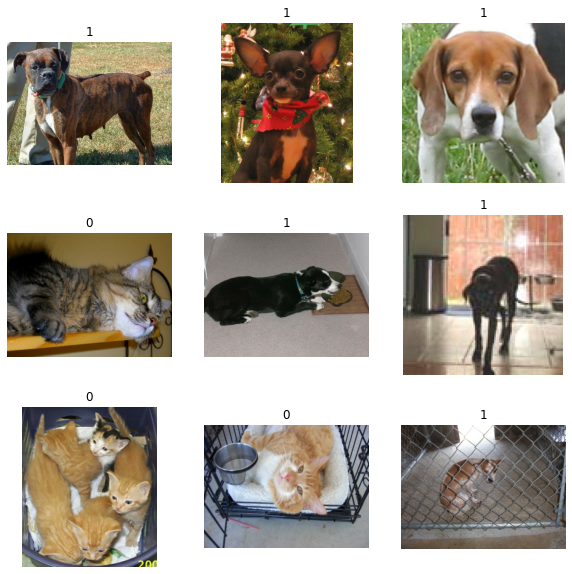

In [380]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [381]:
# Resize images to 150x150
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [382]:
# Besides, let's batch the data and use caching & prefetching to optimize loading speed.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

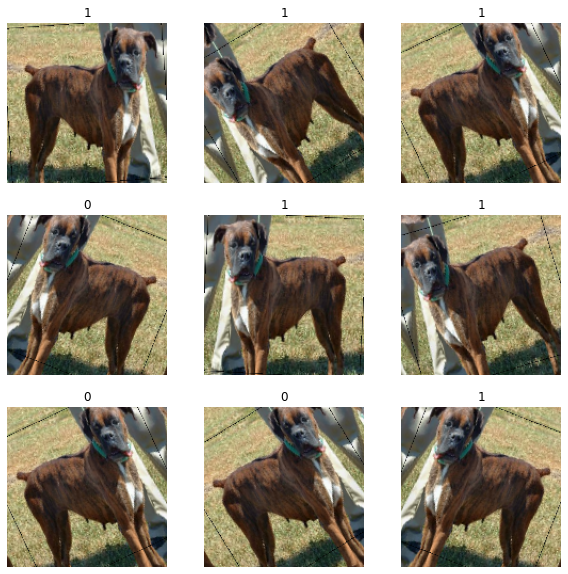

In [383]:
# augmentation
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [384]:
train_ds

<DatasetV1Adapter shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>

**UTILIZANDO ResNet50V2**

In [385]:
import keras
# ===== INSTANCIANDO UM MODELO E OS PESOS DO IMAGENET ===== #
base_model = keras.applications.ResNet50V2(weights='imagenet', input_shape = (150,150,3), include_top = False) # load
base_model.trainable = False # CONGELANDO TODAS AS CAMADAS DO MODELO

# ===== CRIANDO UM NOVO MODELO ===== #

inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)

# Normalize: outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2

# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# CRIANDO O NOVO MODELO EM CIMA DA SAÍDA DO MODELO  INSTANCIADO
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_79 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_175 (Dense)            (None, 1)               

In [387]:
%%time
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 58s 200ms/step - loss: 0.1793 - binary_accuracy: 0.9292 - val_loss: 0.0971 - val_binary_accuracy: 0.9652
Epoch 2/20
291/291 [==============================] - 52s 180ms/step - loss: 0.1364 - binary_accuracy: 0.9447 - val_loss: 0.1021 - val_binary_accuracy: 0.9652
Epoch 3/20
291/291 [==============================] - 52s 179ms/step - loss: 0.1270 - binary_accuracy: 0.9486 - val_loss: 0.0864 - val_binary_accuracy: 0.9678
Epoch 4/20
291/291 [==============================] - 52s 179ms/step - loss: 0.1199 - binary_accuracy: 0.9510 - val_loss: 0.1013 - val_binary_accuracy: 0.9639
Epoch 5/20
291/291 [==============================] - 52s 179ms/step - loss: 0.1211 - binary_accuracy: 0.9499 - val_loss: 0.0800 - val_binary_accuracy: 0.9690
Epoch 6/20
291/291 [==============================] - 53s 181ms/step - loss: 0.1145 - binary_accuracy: 0.9527 - val_loss: 0.0895 - val_binary_accuracy: 0.9708
Epoch 7/20
291/291 [==========================

In [403]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

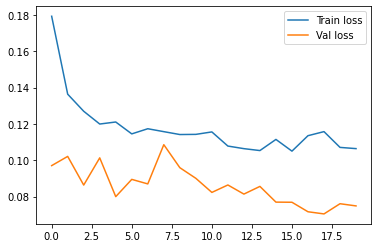

In [433]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['Train loss', 'Val loss'])

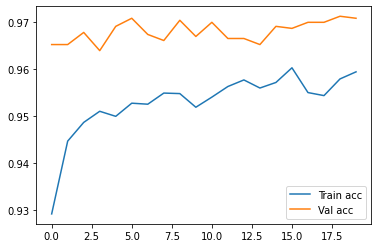

In [434]:
plt.plot(history['binary_accuracy'])
plt.plot(history['val_binary_accuracy'])
plt.legend(['Train acc', 'Val acc'])

In [439]:
# ===== DESCONGELANDO O MODELO E RETREINANDO COM LR MENOR ===== #
%%time
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_79 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_175 (Dense)            (None, 1)               

291/291 [==============================] - 146s 502ms/step - loss: 0.0942 - binary_accuracy: 0.9623 - val_loss: 0.0562 - val_binary_accuracy: 0.9751
Epoch 2/10
291/291 [==============================] - 145s 500ms/step - loss: 0.0657 - binary_accuracy: 0.9733 - val_loss: 0.0578 - val_binary_accuracy: 0.9776
Epoch 3/10
291/291 [==============================] - 145s 499ms/step - loss: 0.0591 - binary_accuracy: 0.9757 - val_loss: 0.0508 - val_binary_accuracy: 0.9772
Epoch 4/10
291/291 [==============================] - 145s 500ms/step - loss: 0.0464 - binary_accuracy: 0.9816 - val_loss: 0.0713 - val_binary_accuracy: 0.9755
Epoch 5/10
291/291 [==============================] - 145s 500ms/step - loss: 0.0406 - binary_accuracy: 0.9852 - val_loss: 0.0512 - val_binary_accuracy: 0.9802
Epoch 6/10
291/291 [==============================] - 145s 500ms/step - loss: 0.0340 - binary_accuracy: 0.9874 - val_loss: 0.0516 - val_binary_accuracy: 0.9802
Epoch 7/10
291/291 [==============================]

In [ ]:
model.evaluate(train_ds)

291/291 [==============================] - 41s 139ms/step - loss: 0.0073 - binary_accuracy: 0.9974


[0.007300891913473606, 0.9974207282066345]

In [ ]:
model.evaluate(validation_ds)

73/73 [==============================] - 10s 137ms/step - loss: 0.0671 - binary_accuracy: 0.9798


[0.0670524314045906, 0.9797936081886292]

In [ ]:
model.evaluate(test_ds)

73/73 [==============================] - 10s 141ms/step - loss: 0.0791 - binary_accuracy: 0.9794


[0.07914692908525467, 0.979363739490509]

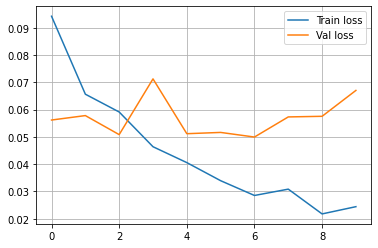

In [448]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.grid()

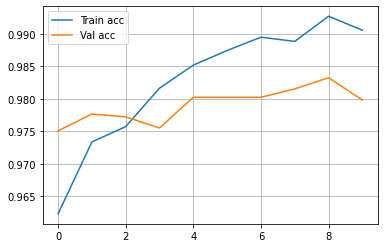

In [451]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['Train acc', 'Val acc'])
plt.grid()

**UTILIZANDO VGG16**

In [467]:
import keras
# IMPORTANDO UM MODELO E OS PESOS DO IMAGENET
base_model = keras.applications.VGG16(weights='imagenet', input_shape = (150,150,3), include_top = False) # load
base_model.trainable = False #Freeze

# CRIANDO UM NOVO MODELO
inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)

# Normalize: outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_79 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_18  (None, 512)               0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_180 (Dense)            (None, 1)               

In [469]:
%%time
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 61s 210ms/step - loss: 0.4269 - binary_accuracy: 0.7951 - val_loss: 0.2852 - val_binary_accuracy: 0.8865
Epoch 2/20
291/291 [==============================] - 61s 210ms/step - loss: 0.3344 - binary_accuracy: 0.8489 - val_loss: 0.2397 - val_binary_accuracy: 0.9020
Epoch 3/20
291/291 [==============================] - 61s 209ms/step - loss: 0.3019 - binary_accuracy: 0.8637 - val_loss: 0.2171 - val_binary_accuracy: 0.9119
Epoch 4/20
291/291 [==============================] - 61s 209ms/step - loss: 0.2860 - binary_accuracy: 0.8650 - val_loss: 0.2045 - val_binary_accuracy: 0.9153
Epoch 5/20
291/291 [==============================] - 61s 208ms/step - loss: 0.2773 - binary_accuracy: 0.8722 - val_loss: 0.1972 - val_binary_accuracy: 0.9226
Epoch 6/20
291/291 [==============================] - 61s 209ms/step - loss: 0.2642 - binary_accuracy: 0.8777 - val_loss: 0.1899 - val_binary_accuracy: 0.9230
Epoch 7/20
291/291 [==========================

In [470]:
model.evaluate(train_ds)
model.evaluate(validation_ds)
model.evaluate(test_ds)

73/73 [==============================] - 12s 161ms/step - loss: 0.1690 - binary_accuracy: 0.9316


[0.16895125806331635, 0.9316422939300537]

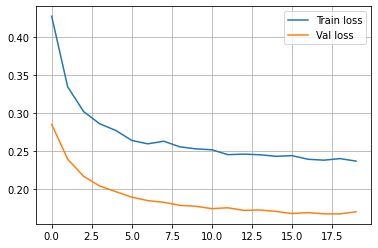

In [471]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.grid()

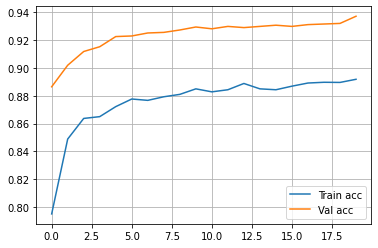

In [472]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['Train acc', 'Val acc'])
plt.grid()

In [473]:
%%time
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_108 (InputLayer)       [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_79 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
normalization_4 (Normalizati (None, 150, 150, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_18  (None, 512)               0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_180 (Dense)            (None, 1)               

291/291 [==============================] - 164s 563ms/step - loss: 0.1572 - binary_accuracy: 0.9315 - val_loss: 0.0682 - val_binary_accuracy: 0.9673
Epoch 2/10
291/291 [==============================] - 164s 562ms/step - loss: 0.0979 - binary_accuracy: 0.9597 - val_loss: 0.0578 - val_binary_accuracy: 0.9755
Epoch 3/10
291/291 [==============================] - 164s 562ms/step - loss: 0.0715 - binary_accuracy: 0.9707 - val_loss: 0.0567 - val_binary_accuracy: 0.9755
Epoch 4/10
291/291 [==============================] - 164s 562ms/step - loss: 0.0589 - binary_accuracy: 0.9753 - val_loss: 0.0505 - val_binary_accuracy: 0.9794
Epoch 5/10
291/291 [==============================] - 164s 562ms/step - loss: 0.0513 - binary_accuracy: 0.9797 - val_loss: 0.0672 - val_binary_accuracy: 0.9772
Epoch 6/10
291/291 [==============================] - 164s 562ms/step - loss: 0.0440 - binary_accuracy: 0.9817 - val_loss: 0.0487 - val_binary_accuracy: 0.9811
Epoch 7/10
291/291 [==============================]

In [474]:
model.evaluate(train_ds)

291/291 [==============================] - 47s 163ms/step - loss: 0.0082 - binary_accuracy: 0.9973


[0.008158518001437187, 0.9973132610321045]

In [475]:
model.evaluate(validation_ds)

73/73 [==============================] - 12s 160ms/step - loss: 0.0471 - binary_accuracy: 0.9815


[0.04705146700143814, 0.9815133213996887]

In [478]:
model.evaluate(test_ds)

73/73 [==============================] - 12s 161ms/step - loss: 0.0697 - binary_accuracy: 0.9807


[0.06971491128206253, 0.9806534647941589]

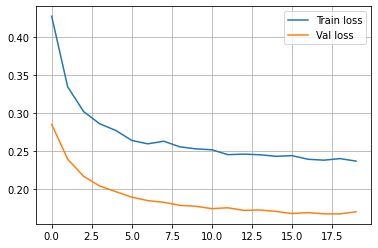

In [476]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Val loss'])
plt.grid()

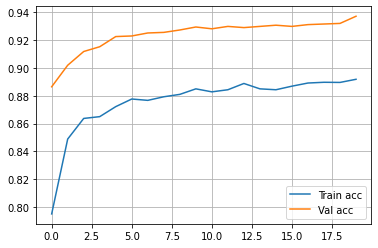

In [477]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.legend(['Train acc', 'Val acc'])
plt.grid()

# 3. (OPCIONAL) Visualizando os padrões aprendidos

1. (OPCIONAL) Para alguma rede convolucional à sua escolha, visualize o que cada camada da rede "aprendeu"; mais precisamente, mostre exemplos de imagens de entrada que maximizam a ativação dos filtros em cada camada. Para isso, siga este [tutorial](https://keras.io/examples/vision/visualizing_what_convnets_learn/).